# Sea Ice Diagnostics and LENS comparison

This notebook contains:
- Annual Mean Timeseries plots
- Annual cycle plots of Ice Area, Ice Volume, and Snow Volume
- Monthly analysis for min and max months
- Labrador Sea Timeseries

In [1]:
import os

import xarray as xr
import numpy as np
import yaml
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import nc_time_axis

In [2]:
CESM_output_dir = ""  # "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
ts_dir = None  # "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
base_case_output_dir = None  # None => use CESM_output_dir
case_name = ""  # "b.e30_beta02.BLT1850.ne30_t232.104"
base_case_name = None  # "b.e23_alpha17f.BLT1850.ne30_t232.092"

start_date = ""  # "0001-01-01"
end_date = ""  # "0101-01-01"
base_start_date = ""  # "0001-01-01"
base_end_date = None  # "0101-01-01"

obs_data_dir = ""  # "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data"
path_model = ""  # "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_model_data/ice/"
grid_file = ""  # "/glade/campaign/cesm/community/omwg/grids/tx2_3v2_grid.nc"
climo_nyears = 35

serial = False  # use dask LocalCluster

lc_kwargs = {}

In [3]:
# Parameters
case_name = "b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.241"
base_case_name = "b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.234"
case_nickname = "BLT1850_241"
base_case_nickname = "BLT1850_234"
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
start_date = "0001-01-01"
end_date = "0041-01-01"
climo_start_year = 21
climo_end_year = 41
base_start_date = "0001-01-01"
base_end_date = "0081-01-01"
base_climo_start_year = 61
base_climo_end_year = 81
obs_data_dir = (
    "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data"
)
ts_dir = None
lc_kwargs = {"threads_per_worker": 1}
serial = False
climo_nyears = 35
grid_file = "/glade/campaign/cesm/community/omwg/grids/tx2_3v2_grid.nc"
path_model = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_model_data/ice/"
subset_kwargs = {}
product = "/glade/work/tking/cupid_project/other_cupids/234v241/CUPiD/examples/key_metrics/computed_notebooks//ice/Hemis_seaice_visual_compare_obs_lens.ipynb"


In [4]:
# Want some base case parameter defaults to equal control case values
if base_case_name is not None:
    if base_case_output_dir is None:
        base_case_output_dir = CESM_output_dir

    if base_end_date is None:
        base_end_date = end_date

if ts_dir is None:
    ts_dir = CESM_output_dir

In [5]:
# When running interactively, cupid_run should be set to 0 for
# a DASK cluster

cupid_run = 1

if cupid_run == 1:

    from dask.distributed import Client, LocalCluster

    # Spin up cluster (if running in parallel)
    client = None
    if not serial:
        cluster = LocalCluster(**lc_kwargs)
        client = Client(cluster)

else:

    from dask.distributed import Client
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster(
        cores=16,
        processes=16,
        memory="100GB",
        account="P93300065",
        queue="casper",
        walltime="02:00:00",
    )

    client = Client(cluster)

    cluster.scale(1)

    print(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39543,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42251,Total threads: 1
Dashboard: http://127.0.0.1:46127/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:42525,


# Read in data

# New CESM cases to compare

In [6]:
# Read in two cases. The ADF timeseries are needed here.

ds1 = xr.open_mfdataset(
    os.path.join(
        ts_dir, case_name, "ice", "proc", "tseries", f"{case_name}.cice.h.*.nc"
    ),
    data_vars="minimal",
    compat="override",
    coords="minimal",
).sel(time=slice(start_date, end_date))

ds2 = xr.open_mfdataset(
    os.path.join(
        ts_dir,
        base_case_name,
        "ice",
        "proc",
        "tseries",
        f"{base_case_name}.cice.h.*.nc",
    ),
    data_vars="minimal",
    compat="override",
    coords="minimal",
).sel(time=slice(base_start_date, base_end_date))

ds_grid = xr.open_dataset(grid_file)
TLAT = ds_grid["TLAT"]
TLON = ds_grid["TLONG"]
tarea = ds_grid["TAREA"] * 1.0e-4
angle = ds_grid["ANGLE"]

ds1_ann = ds1.resample(time="YS").mean(dim="time")
ds2_ann = ds2.resample(time="YS").mean(dim="time")

climo_nyears1 = min(climo_nyears, len(ds1_ann.time))
climo_nyears2 = min(climo_nyears, len(ds2_ann.time))

with open("cice_masks.yml", "r") as file:
    cice_masks = yaml.safe_load(file)

first_year = int(start_date.split("-")[0])
base_first_year = int(base_start_date.split("-")[0])
end_year = int(end_date.split("-")[0])
base_end_year = int(base_end_date.split("-")[0])

path_lens1 = os.path.join(path_model, "cesm_lens1")
path_lens2 = os.path.join(path_model, "cesm_lens2")

path_cdr = os.path.join(
    obs_data_dir, "ice", "analysis_datasets", "hemispheric_data", "CDR_area_timeseries/"
)

# Define Functions

In [7]:
# Two functions to help draw plots even if only one year of data is available
# If one year is present, horizontal line will be dotted instead of solid


def da_plot_len_time_might_be_one(da_in, alt_time, color):
    # If da_in.time only has 1 value, draw horizontal line across range of alt_time
    if len(da_in.time) > 1:
        da_in.plot(color=color)
    else:
        time_arr = [alt_time.data[0], alt_time.data[-1]]
        plt.plot(time_arr, [da_in.data[0], da_in.data[0]], linestyle=":", color=color)


def plt_plot_len_x_might_be_one(da_in, x_in, alt_x, color):
    # If x_in only has one value, draw horizontal line across range of alt_x
    if len(x_in) > 1:
        plt.plot(x_in, da_in, color=color)
    else:
        plt.plot(
            [alt_x[0], alt_x[-1]],
            [da_in.data[0], da_in.data[0]],
            linestyle=":",
            color=color,
        )

In [8]:
def setBoxColor(boxplot, colors):

    # Set edge color of the outside and median lines of the boxes
    for element in ["boxes", "medians"]:
        for box, color in zip(boxplot[element], colors):
            plt.setp(box, color=color, linewidth=3)

    # Set the color of the whiskers and caps of the boxes
    for element in ["whiskers", "caps"]:
        for box, color in zip(
            zip(boxplot[element][::2], boxplot[element][1::2]), colors
        ):
            plt.setp(box, color=color, linewidth=3)

# Read in CESM LENS Data

In [9]:
### Read in the CESM LENS historical data

ds_cesm1_aicetot_nh = xr.open_dataset(path_lens1 + "/LE_aicetot_nh_1920-2100.nc")
ds_cesm1_hitot_nh = xr.open_dataset(path_lens1 + "/LE_hitot_nh_1920-2100.nc")
ds_cesm1_hstot_nh = xr.open_dataset(path_lens1 + "/LE_hstot_nh_1920-2100.nc")

ds_cesm1_aicetot_sh = xr.open_dataset(path_lens1 + "/LE_aicetot_sh_1920-2100.nc")
ds_cesm1_hitot_sh = xr.open_dataset(path_lens1 + "/LE_hitot_sh_1920-2100.nc")
ds_cesm1_hstot_sh = xr.open_dataset(path_lens1 + "/LE_hstot_sh_1920-2100.nc")

cesm1_aicetot_nh_ann = ds_cesm1_aicetot_nh["aice_monthly"].mean(dim="nmonth")
cesm1_hitot_nh_ann = ds_cesm1_hitot_nh["hi_monthly"].mean(dim="nmonth")
cesm1_hstot_nh_ann = ds_cesm1_hstot_nh["hs_monthly"].mean(dim="nmonth")

cesm1_aicetot_sh_ann = ds_cesm1_aicetot_sh["aice_monthly"].mean(dim="nmonth")
cesm1_hitot_sh_ann = ds_cesm1_hitot_sh["hi_monthly"].mean(dim="nmonth")
cesm1_hstot_sh_ann = ds_cesm1_hstot_sh["hs_monthly"].mean(dim="nmonth")

if first_year > 1 and base_first_year > 1:
    cesm1_years = np.linspace(1920, 2100, 181)
else:
    cesm1_years = np.linspace(1, 181, 181)

cesm1_aicetot_nh_month = ds_cesm1_aicetot_nh["aice_monthly"][:, 60:95, :].mean(
    dim="nyr"
)
cesm1_hitot_nh_month = ds_cesm1_hitot_nh["hi_monthly"][:, 60:95, :].mean(dim="nyr")
cesm1_hstot_nh_month = ds_cesm1_hstot_nh["hs_monthly"][:, 60:95, :].mean(dim="nyr")
cesm1_aicetot_sh_month = ds_cesm1_aicetot_sh["aice_monthly"][:, 60:95, :].mean(
    dim="nyr"
)
cesm1_hitot_sh_month = ds_cesm1_hitot_sh["hi_monthly"][:, 60:95, :].mean(dim="nyr")
cesm1_hstot_sh_month = ds_cesm1_hstot_sh["hs_monthly"][:, 60:95, :].mean(dim="nyr")

ds_cesm2_aicetot_nh = xr.open_dataset(path_lens2 + "/LE2_aicetot_nh_1870-2100.nc")
ds_cesm2_hitot_nh = xr.open_dataset(path_lens2 + "/LE2_hitot_nh_1870-2100.nc")
ds_cesm2_hstot_nh = xr.open_dataset(path_lens2 + "/LE2_hstot_nh_1870-2100.nc")

ds_cesm2_aicetot_sh = xr.open_dataset(path_lens2 + "/LE2_aicetot_sh_1870-2100.nc")
ds_cesm2_hitot_sh = xr.open_dataset(path_lens2 + "/LE2_hitot_sh_1870-2100.nc")
ds_cesm2_hstot_sh = xr.open_dataset(path_lens2 + "/LE2_hstot_sh_1870-2100.nc")

cesm2_aicetot_nh_ann = ds_cesm2_aicetot_nh["aice_monthly"].mean(dim="nmonth")
cesm2_hitot_nh_ann = ds_cesm2_hitot_nh["hi_monthly"].mean(dim="nmonth")
cesm2_hstot_nh_ann = ds_cesm2_hstot_nh["hs_monthly"].mean(dim="nmonth")

cesm2_aicetot_sh_ann = ds_cesm2_aicetot_sh["aice_monthly"].mean(dim="nmonth")
cesm2_hitot_sh_ann = ds_cesm2_hitot_sh["hi_monthly"].mean(dim="nmonth")
cesm2_hstot_sh_ann = ds_cesm2_hstot_sh["hs_monthly"].mean(dim="nmonth")

if first_year > 1 and base_first_year > 1:
    cesm2_years = np.linspace(1870, 2100, 229)
else:
    cesm2_years = np.linspace(1, 229, 229)

cesm2_aicetot_nh_month = ds_cesm2_aicetot_nh["aice_monthly"][:, 110:145, :].mean(
    dim="nyr"
)
cesm2_hitot_nh_month = ds_cesm2_hitot_nh["hi_monthly"][:, 110:145, :].mean(dim="nyr")
cesm2_hstot_nh_month = ds_cesm2_hstot_nh["hs_monthly"][:, 110:145, :].mean(dim="nyr")
cesm2_aicetot_sh_month = ds_cesm2_aicetot_sh["aice_monthly"][:, 110:145, :].mean(
    dim="nyr"
)
cesm2_hitot_sh_month = ds_cesm2_hitot_sh["hi_monthly"][:, 110:145, :].mean(dim="nyr")
cesm2_hstot_sh_month = ds_cesm2_hstot_sh["hs_monthly"][:, 110:145, :].mean(dim="nyr")

In [10]:
# Set up legends

p1 = mlines.Line2D([], [], color="lightgrey", label="CESM1-LENS")
p2 = mlines.Line2D([], [], color="lightblue", label="CESM2-LENS")
p3 = mlines.Line2D([], [], color="red", label=case_name)
p4 = mlines.Line2D([], [], color="blue", label=base_case_name)
p5 = mlines.Line2D([], [], color="black", label="NOAA NASA CDR")

# Annual Mean Timeseries plots

In [11]:
### Read in NOAA NASA CDR Timeseries

cdr_nh = xr.open_dataset(path_cdr + "CDR_sic_nh_monthly.nc")
cdr_sh = xr.open_dataset(path_cdr + "CDR_sic_sh_monthly.nc")
cdr_lab = xr.open_dataset(path_cdr + "CDR_sic_lab_monthly.nc")

cdr_nh_mar = cdr_nh["sic_monthly"].sel(time=(cdr_nh.time.dt.month == 3))
cdr_sh_feb = cdr_sh["sic_monthly"].sel(time=(cdr_nh.time.dt.month == 2))
cdr_nh_sep = cdr_nh["sic_monthly"].sel(time=(cdr_nh.time.dt.month == 9))
cdr_sh_sep = cdr_sh["sic_monthly"].sel(time=(cdr_nh.time.dt.month == 9))
cdr_lab_mar = cdr_lab["sic_monthly_lab"].sel(time=(cdr_nh.time.dt.month == 3))

cdr_nh_clim = (
    cdr_nh["sic_monthly"]
    .isel(time=slice(-420, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)

cdr_sh_clim = (
    cdr_sh["sic_monthly"]
    .isel(time=slice(-420, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)

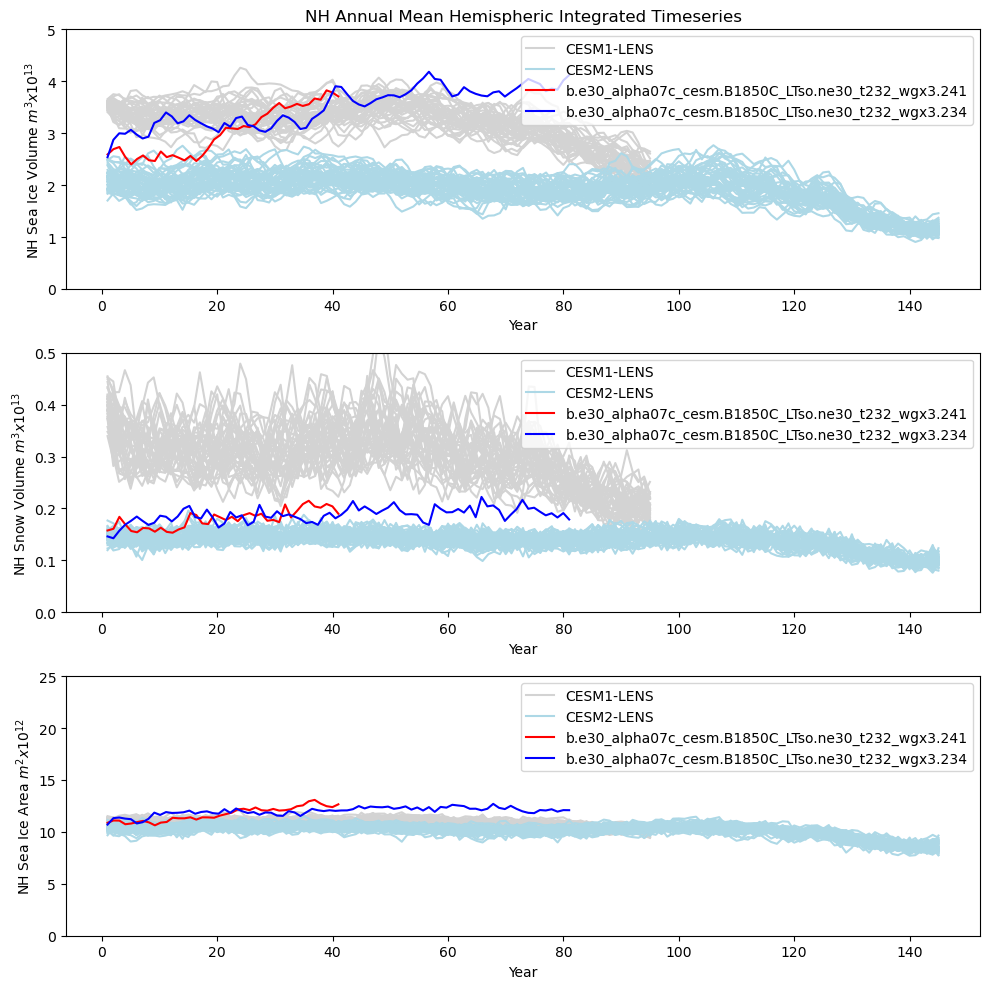

In [12]:
# Northern hemisphere timeseries plot
tag = "NH"

ds1_area_ann = (tarea * ds1_ann["aice"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_ann = (tarea * ds2_ann["aice"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_vhi_ann = (tarea * ds1_ann["hi"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhi_ann = (tarea * ds2_ann["hi"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

ds1_vhs_ann = (tarea * ds1_ann["hs"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhs_ann = (tarea * ds2_ann["hs"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

# Set up axes
if first_year > 1 and base_first_year > 1:
    model_start_year1 = end_year - len(ds1_area_ann.time) + 1
    model_end_year1 = end_year
    model_start_year2 = base_end_year - len(ds2_area_ann.time) + 1
    model_end_year2 = base_end_year
else:
    model_start_year1 = 1
    model_end_year1 = len(ds1_area_ann.time) + 1
    model_start_year2 = 1
    model_end_year2 = len(ds2_area_ann.time) + 1

x1 = np.linspace(model_start_year1, model_end_year1, len(ds1_area_ann.time))
x2 = np.linspace(model_start_year2, model_end_year2, len(ds2_area_ann.time))

fig = plt.figure(figsize=(10, 10), tight_layout=True)

ax = fig.add_subplot(3, 1, 1)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_hitot_nh_ann[i, 0:95] * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], cesm2_hitot_nh_ann[i, 0:145] * 1.0e-13, color="lightblue"
    )
plt_plot_len_x_might_be_one(ds1_vhi_ann, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_vhi_ann, x2, x1, color="blue")

plt.title(tag + " Annual Mean Hemispheric Integrated Timeseries")
plt.ylim((0, 5))
plt.xlabel("Year")
plt.ylabel(tag + " Sea Ice Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

ax = fig.add_subplot(3, 1, 2)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_hstot_nh_ann[i, 0:95] * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], cesm2_hstot_nh_ann[i, 0:145] * 1.0e-13, color="lightblue"
    )
plt_plot_len_x_might_be_one(ds1_vhs_ann, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_vhs_ann, x2, x1, color="blue")

plt.ylim((0, 0.5))
plt.xlabel("Year")
plt.ylabel(tag + " Snow Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

ax = fig.add_subplot(3, 1, 3)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_aicetot_nh_ann[i, 0:95] * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], cesm2_aicetot_nh_ann[i, 0:145] * 1.0e-12, color="lightblue"
    )

plt_plot_len_x_might_be_one(ds1_area_ann, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_area_ann, x2, x1, color="blue")

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel(tag + " Sea Ice Area $m^{2} x 10^{12}$")
plt.legend(handles=[p1, p2, p3, p4])

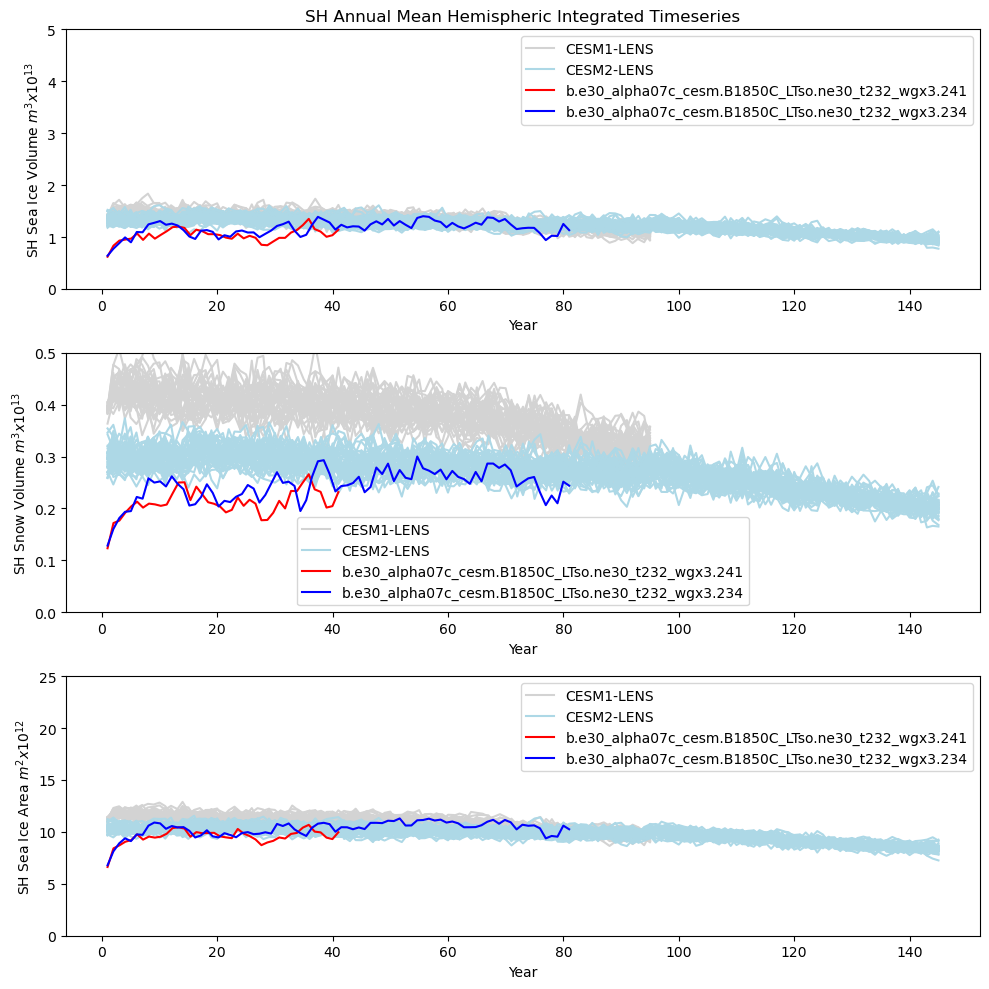

In [13]:
# Southern hemisphere timeseries plot
tag = "SH"

ds1_area_ann = (tarea * ds1_ann["aice"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_ann = (tarea * ds2_ann["aice"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_vhi_ann = (tarea * ds1_ann["hi"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhi_ann = (tarea * ds2_ann["hi"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13

ds1_vhs_ann = (tarea * ds1_ann["hs"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhs_ann = (tarea * ds2_ann["hs"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13

fig = plt.figure(figsize=(10, 10), tight_layout=True)

ax = fig.add_subplot(3, 1, 1)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_hitot_sh_ann[i, 0:95] * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], cesm2_hitot_sh_ann[i, 0:145] * 1.0e-13, color="lightblue"
    )
plt_plot_len_x_might_be_one(ds1_vhi_ann, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_vhi_ann, x2, x1, color="blue")

plt.title(tag + " Annual Mean Hemispheric Integrated Timeseries")
plt.ylim((0, 5))
plt.xlabel("Year")
plt.ylabel(tag + " Sea Ice Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

ax = fig.add_subplot(3, 1, 2)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_hstot_sh_ann[i, 0:95] * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], cesm2_hstot_sh_ann[i, 0:145] * 1.0e-13, color="lightblue"
    )
plt_plot_len_x_might_be_one(ds1_vhs_ann, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_vhs_ann, x2, x1, color="blue")

plt.ylim((0, 0.5))
plt.xlabel("Year")
plt.ylabel(tag + " Snow Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

ax = fig.add_subplot(3, 1, 3)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_aicetot_sh_ann[i, 0:95] * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], cesm2_aicetot_sh_ann[i, 0:145] * 1.0e-12, color="lightblue"
    )
plt_plot_len_x_might_be_one(ds1_area_ann, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_area_ann, x2, x1, color="blue")

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel(tag + " Sea Ice Area $m^{2} x 10^{12}$")
plt.legend(handles=[p1, p2, p3, p4])

# Annual cycle plots - Ice Area

In [14]:
# get monthly means from test data
aice1_month = (
    ds1["aice"]
    .isel(time=slice(-climo_nyears1 * 12, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)
aice2_month = (
    ds2["aice"]
    .isel(time=slice(-climo_nyears2 * 12, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)

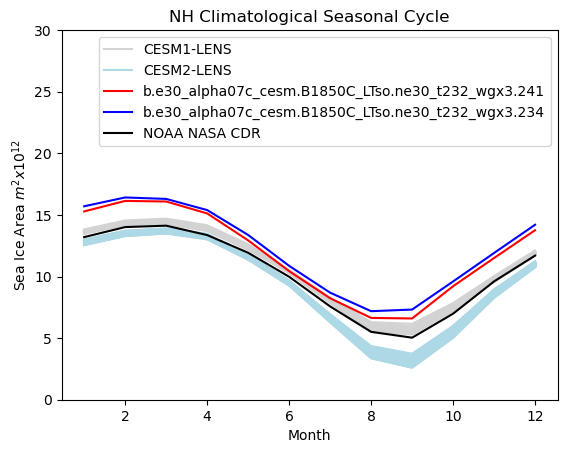

In [15]:
# Northern hemisphere annual cycle plot
tag = "NH"

mask_tmp1_nh = np.where(np.logical_and(aice1_month > 0.15, ds1["TLAT"] > 0), 1.0, 0.0)
mask_tmp2_nh = np.where(np.logical_and(aice2_month > 0.15, ds1["TLAT"] > 0), 1.0, 0.0)

mask_nh_tmp = np.where(ds1["TLAT"] > 0, tarea, 0.0)
mask_nh = xr.DataArray(data=mask_nh_tmp, dims=["nj", "ni"])

area1 = (aice1_month * mask_nh).sum(["ni", "nj"]) * 1.0e-12
area2 = (aice2_month * mask_nh).sum(["ni", "nj"]) * 1.0e-12

months = np.linspace(1, 12, 12)

for i in range(0, 38):
    plt.plot(months, cesm1_aicetot_nh_month[i, :] * 1.0e-12, color="lightgrey")
for i in range(0, 49):
    plt.plot(months, cesm2_aicetot_nh_month[i, :] * 1.0e-12, color="lightblue")
plt.plot(months, area1, color="red")
plt.plot(months, area2, color="blue")
plt.plot(months, cdr_nh_clim, color="black")

plt.title(tag + " Climatological Seasonal Cycle")
plt.ylim((0, 30))
plt.xlabel("Month")
plt.ylabel("Sea Ice Area $m^{2} x 10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

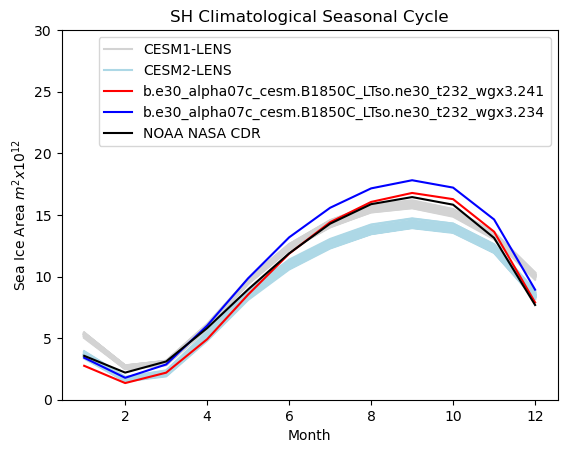

In [16]:
# Southern hemisphere annual cycle plot
tag = "SH"

mask_tmp1_sh = np.where(np.logical_and(aice1_month > 0.15, ds1["TLAT"] < 0), 1.0, 0.0)
mask_tmp2_sh = np.where(np.logical_and(aice2_month > 0.15, ds1["TLAT"] < 0), 1.0, 0.0)

mask_sh_tmp = np.where(ds1["TLAT"] < 0, tarea, 0.0)
mask_sh = xr.DataArray(data=mask_sh_tmp, dims=["nj", "ni"])

area1 = (aice1_month * mask_sh).sum(["ni", "nj"]) * 1.0e-12
area2 = (aice2_month * mask_sh).sum(["ni", "nj"]) * 1.0e-12

for i in range(0, 38):
    plt.plot(months, cesm1_aicetot_sh_month[i, :] * 1.0e-12, color="lightgrey")
for i in range(0, 49):
    plt.plot(months, cesm2_aicetot_sh_month[i, :] * 1.0e-12, color="lightblue")
plt.plot(months, area1, color="red")
plt.plot(months, area2, color="blue")
plt.plot(months, cdr_sh_clim, color="black")

plt.title(tag + " Climatological Seasonal Cycle")
plt.ylim((0, 30))
plt.xlabel("Month")
plt.ylabel("Sea Ice Area $m^{2} x 10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

# Annual cycle plots - Ice Volume

In [17]:
# get monthly means from test data
hi1_month = (
    ds1["hi"]
    .isel(time=slice(-climo_nyears1 * 12, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)
hi2_month = (
    ds2["hi"]
    .isel(time=slice(-climo_nyears2 * 12, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)

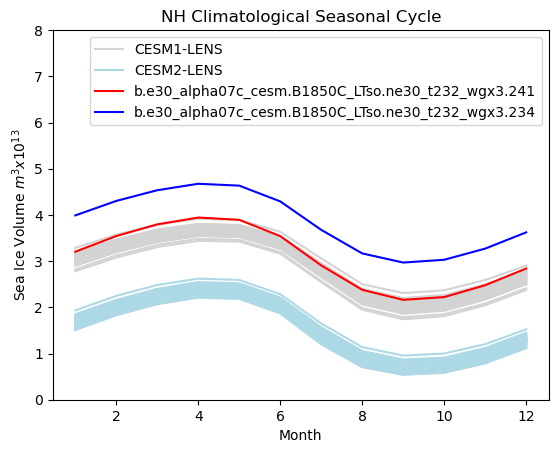

In [18]:
# Northern hemisphere annual cycle plot
tag = "NH"

mask_tmp1_nh = np.where(np.logical_and(hi1_month > 0, ds1["TLAT"] > 0), 1.0, 0.0)
mask_tmp2_nh = np.where(np.logical_and(hi2_month > 0, ds1["TLAT"] > 0), 1.0, 0.0)

mask_nh_tmp = np.where(ds1["TLAT"] > 0, tarea, 0.0)
mask_nh = xr.DataArray(data=mask_nh_tmp, dims=["nj", "ni"])

vol1 = (hi1_month * mask_nh).sum(["ni", "nj"]) * 1.0e-13
vol2 = (hi2_month * mask_nh).sum(["ni", "nj"]) * 1.0e-13

months = np.linspace(1, 12, 12)

for i in range(0, 38):
    plt.plot(months, cesm1_hitot_nh_month[i, :] * 1.0e-13, color="lightgrey")
for i in range(0, 49):
    plt.plot(months, cesm2_hitot_nh_month[i, :] * 1.0e-13, color="lightblue")
plt.plot(months, vol1, color="red")
plt.plot(months, vol2, color="blue")

plt.title(tag + " Climatological Seasonal Cycle")
plt.ylim((0, 8))
plt.xlabel("Month")
plt.ylabel("Sea Ice Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

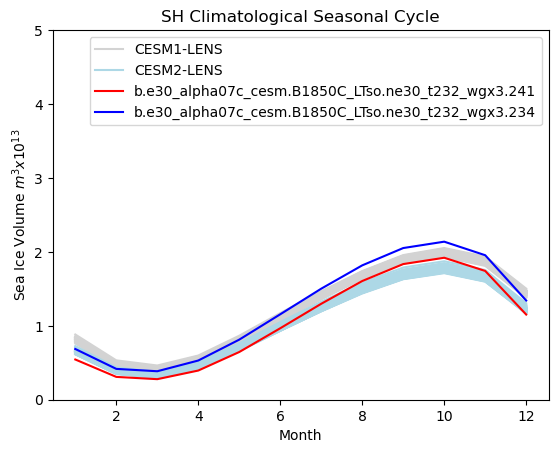

In [19]:
# Southern hemisphere annual cycle plot
tag = "SH"

mask_tmp1_sh = np.where(np.logical_and(hi1_month > 0, ds1["TLAT"] < 0), 1.0, 0.0)
mask_tmp2_sh = np.where(np.logical_and(hi2_month > 0, ds1["TLAT"] < 0), 1.0, 0.0)

mask_sh_tmp = np.where(ds1["TLAT"] < 0, tarea, 0.0)
mask_sh = xr.DataArray(data=mask_sh_tmp, dims=["nj", "ni"])

vol1 = (hi1_month * mask_sh).sum(["ni", "nj"]) * 1.0e-13
vol2 = (hi2_month * mask_sh).sum(["ni", "nj"]) * 1.0e-13

months = np.linspace(1, 12, 12)

for i in range(0, 38):
    plt.plot(months, cesm1_hitot_sh_month[i, :] * 1.0e-13, color="lightgrey")
for i in range(0, 49):
    plt.plot(months, cesm2_hitot_sh_month[i, :] * 1.0e-13, color="lightblue")
plt.plot(months, vol1, color="red")
plt.plot(months, vol2, color="blue")

plt.title(tag + " Climatological Seasonal Cycle")
plt.ylim((0, 5))
plt.xlabel("Month")
plt.ylabel("Sea Ice Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

# Annual cycle plots - Snow volume

In [20]:
# get monthly means from test data
hs1_month = (
    ds1["hs"]
    .isel(time=slice(-climo_nyears1 * 12, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)
hs2_month = (
    ds2["hs"]
    .isel(time=slice(-climo_nyears2 * 12, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)

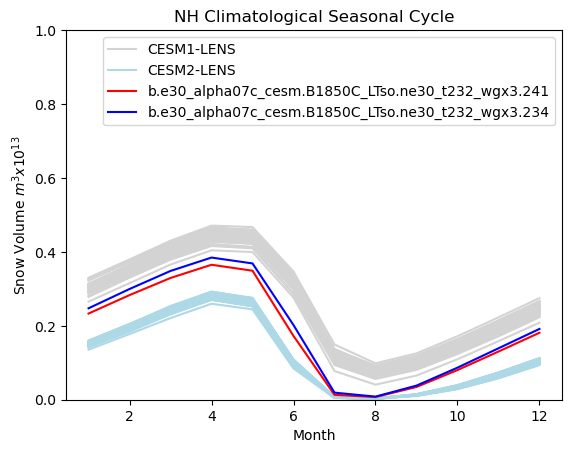

In [21]:
# Northern hemisphere annual cycle plot
tag = "NH"

mask_tmp1_nh = np.where(np.logical_and(hs1_month > 0, ds1["TLAT"] > 0), 1.0, 0.0)
mask_tmp2_nh = np.where(np.logical_and(hs2_month > 0, ds1["TLAT"] > 0), 1.0, 0.0)

mask_nh_tmp = np.where(ds1["TLAT"] > 0, tarea, 0.0)
mask_nh = xr.DataArray(data=mask_nh_tmp, dims=["nj", "ni"])

vol1 = (hs1_month * mask_nh).sum(["ni", "nj"]) * 1.0e-13
vol2 = (hs2_month * mask_nh).sum(["ni", "nj"]) * 1.0e-13

months = np.linspace(1, 12, 12)

for i in range(0, 38):
    plt.plot(months, cesm1_hstot_nh_month[i, :] * 1.0e-13, color="lightgrey")
for i in range(0, 49):
    plt.plot(months, cesm2_hstot_nh_month[i, :] * 1.0e-13, color="lightblue")
plt.plot(months, vol1, color="red")
plt.plot(months, vol2, color="blue")

plt.title(tag + " Climatological Seasonal Cycle")
plt.ylim((0, 1))
plt.xlabel("Month")
plt.ylabel("Snow Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

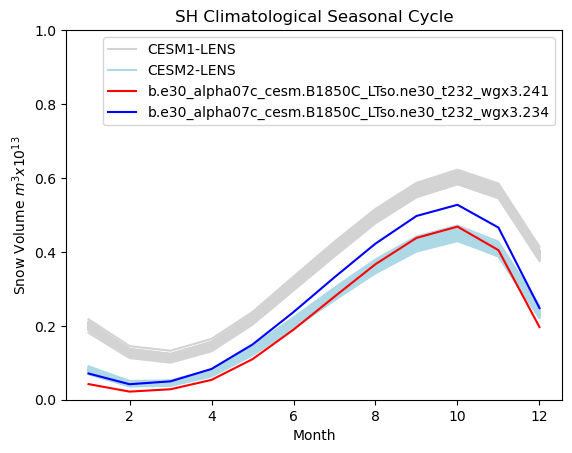

In [22]:
# Southern hemisphere annual cycle plot
tag = "SH"

mask_tmp1_sh = np.where(np.logical_and(hs1_month > 0, ds1["TLAT"] < 0), 1.0, 0.0)
mask_tmp2_sh = np.where(np.logical_and(hs2_month > 0, ds1["TLAT"] < 0), 1.0, 0.0)

mask_sh_tmp = np.where(ds1["TLAT"] < 0, tarea, 0.0)
mask_sh = xr.DataArray(data=mask_sh_tmp, dims=["nj", "ni"])

vol1 = (hs1_month * mask_sh).sum(["ni", "nj"]) * 1.0e-13
vol2 = (hs2_month * mask_sh).sum(["ni", "nj"]) * 1.0e-13

months = np.linspace(1, 12, 12)

for i in range(0, 38):
    plt.plot(months, cesm1_hstot_sh_month[i, :] * 1.0e-13, color="lightgrey")
for i in range(0, 49):
    plt.plot(months, cesm2_hstot_sh_month[i, :] * 1.0e-13, color="lightblue")
plt.plot(months, vol1, color="red")
plt.plot(months, vol2, color="blue")

plt.title(tag + " Climatological Seasonal Cycle")
plt.ylim((0, 1))
plt.xlabel("Month")
plt.ylabel("Snow Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

# Monthly Analysis for Minimum and Maximum Months

## NH
- Maximum - March
- Minimum - September

### Ice Area

In [23]:
ds1_area = (tarea * ds1.aice).isel(time=slice(-climo_nyears1 * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area = (tarea * ds2.aice).isel(time=slice(-climo_nyears2 * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-12

(array([0.25, 0.5 , 0.75, 1.  , 1.25]),
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.0'),
  Text(1.25, 0, '1.25')])

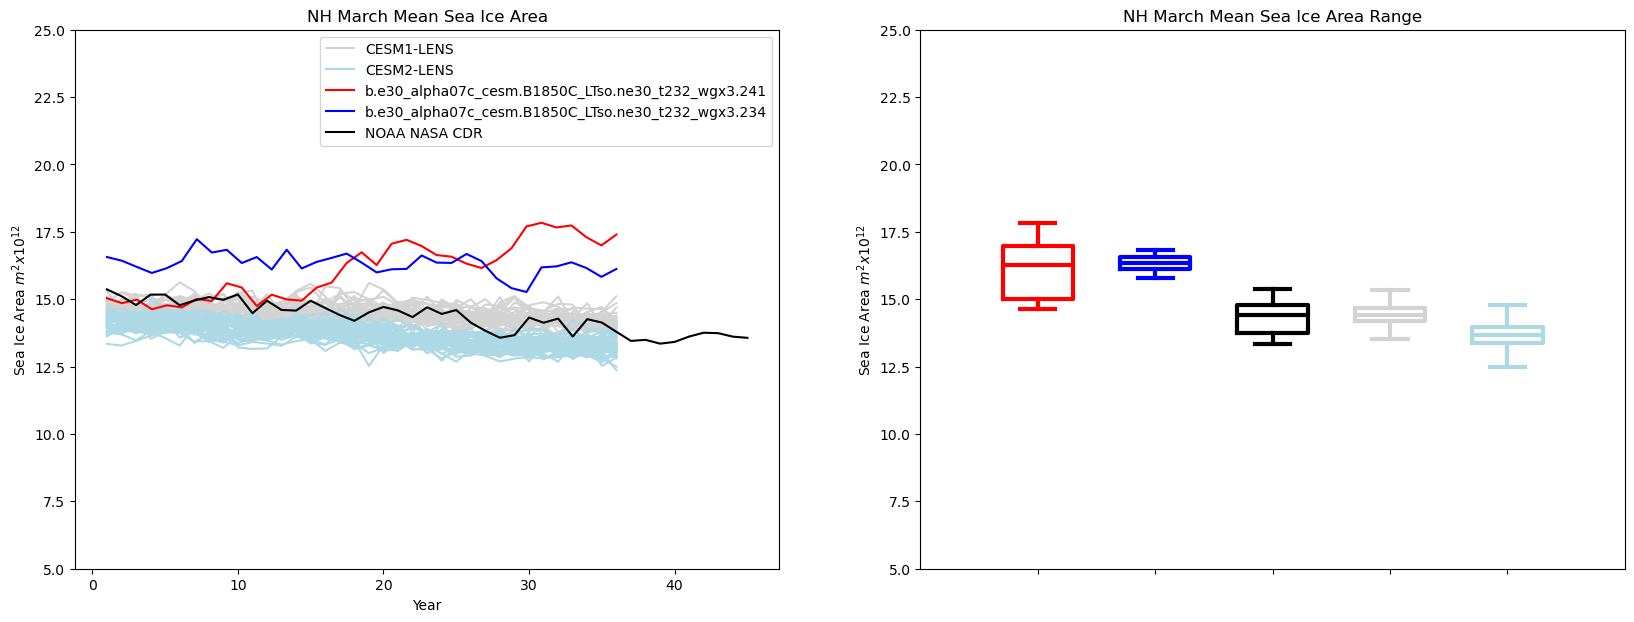

In [24]:
tag = "NH"

ds1_mar_nh = ds1_area.sel(time=(ds1_area.time.dt.month == 3))
ds2_mar_nh = ds2_area.sel(time=(ds2_area.time.dt.month == 3))

cesm1_aicetot_nh_mar = ds_cesm1_aicetot_nh["aice_monthly"].isel(nmonth=2)
cesm2_aicetot_nh_mar = ds_cesm2_aicetot_nh["aice_monthly"].isel(nmonth=2)

cesm1_aicetot_sh_sep = ds_cesm1_aicetot_sh["aice_monthly"].isel(nmonth=8)
cesm2_aicetot_sh_sep = ds_cesm2_aicetot_sh["aice_monthly"].isel(nmonth=8)

# Set up axes
if first_year > 1 and base_first_year > 1:
    model_start_year1 = end_year - len(ds1_mar_nh.time) + 1
    model_end_year1 = end_year
    model_start_year2 = base_end_year - len(ds2_mar_nh.time) + 1
    model_end_year2 = base_end_year
    lens1_start_year = ds_cesm1_aicetot_nh.year[60]
    lens1_end_year = ds_cesm1_aicetot_nh.year[95]
    lens2_start_year = ds_cesm2_aicetot_nh.year[110]
    lens2_end_year = ds_cesm2_aicetot_nh.year[145]
else:
    model_start_year1 = 1
    model_end_year1 = len(ds1_mar_nh.time) + 1
    model_start_year2 = 1
    model_end_year2 = len(ds2_mar_nh.time) + 1
    lens1_start_year = 1
    lens1_end_year = 36
    lens2_start_year = 1
    lens2_end_year = 36

del x1
del x2

x1 = np.linspace(model_start_year1, model_end_year1, len(ds1_mar_nh.time))
x2 = np.linspace(model_start_year2, model_end_year2, len(ds2_mar_nh.time))
x3 = np.linspace(lens1_start_year, lens1_end_year, 36)
x4 = np.linspace(lens2_start_year, lens2_end_year, 36)

obs_first_year = 0
if first_year > 1 and base_first_year > 1:
    obs_first_year = 1979
x6 = np.linspace(1, 45, 45) + obs_first_year

# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left)
fig = plt.figure(figsize=(20, 7))

# First panel, timeseries
ax = fig.add_subplot(1, 2, 1)
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_aicetot_nh_mar.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_aicetot_nh_mar.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-12,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_mar_nh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_mar_nh, x2, x1, color="blue")
ax.plot(x6, cdr_nh_mar, color="black")

plt.title(tag + " March Mean Sea Ice Area")
plt.ylim((5, 25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

### Second panel, boxplot
ax = fig.add_subplot(1, 2, 2)
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = (
    cesm1_aicetot_nh_mar.isel(nyr=slice(60, 96)).stack(new=("n_members", "nyr"))
    * 1.0e-12
)
cesm2_tmp = (
    cesm2_aicetot_nh_mar.isel(nyr=slice(110, 146)).stack(new=("n_members", "nyr"))
    * 1.0e-12
)

# plot boxes
boxplots1 = ax.boxplot(ds1_mar_nh, showfliers=False, autorange=False, positions=[0.25])
boxplots2 = ax.boxplot(ds2_mar_nh, showfliers=False, autorange=False, positions=[0.50])
boxplots3 = ax.boxplot(cdr_nh_mar, showfliers=False, autorange=False, positions=[0.75])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False, positions=[1.00])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False, positions=[1.25])

# set colors for each box
setBoxColor(boxplots1, 8 * ["red"])
setBoxColor(boxplots2, 8 * ["blue"])
setBoxColor(boxplots3, 8 * ["black"])
setBoxColor(boxplots4, 8 * ["lightgrey"])
setBoxColor(boxplots5, 8 * ["lightblue"])

# set plot details
plt.title(tag + " March Mean Sea Ice Area Range")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.ylim((5, 25))
plt.xlim([0, 1.5])
plt.xticks(visible=False)

(array([0.25, 0.5 , 0.75, 1.  , 1.25]),
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.0'),
  Text(1.25, 0, '1.25')])

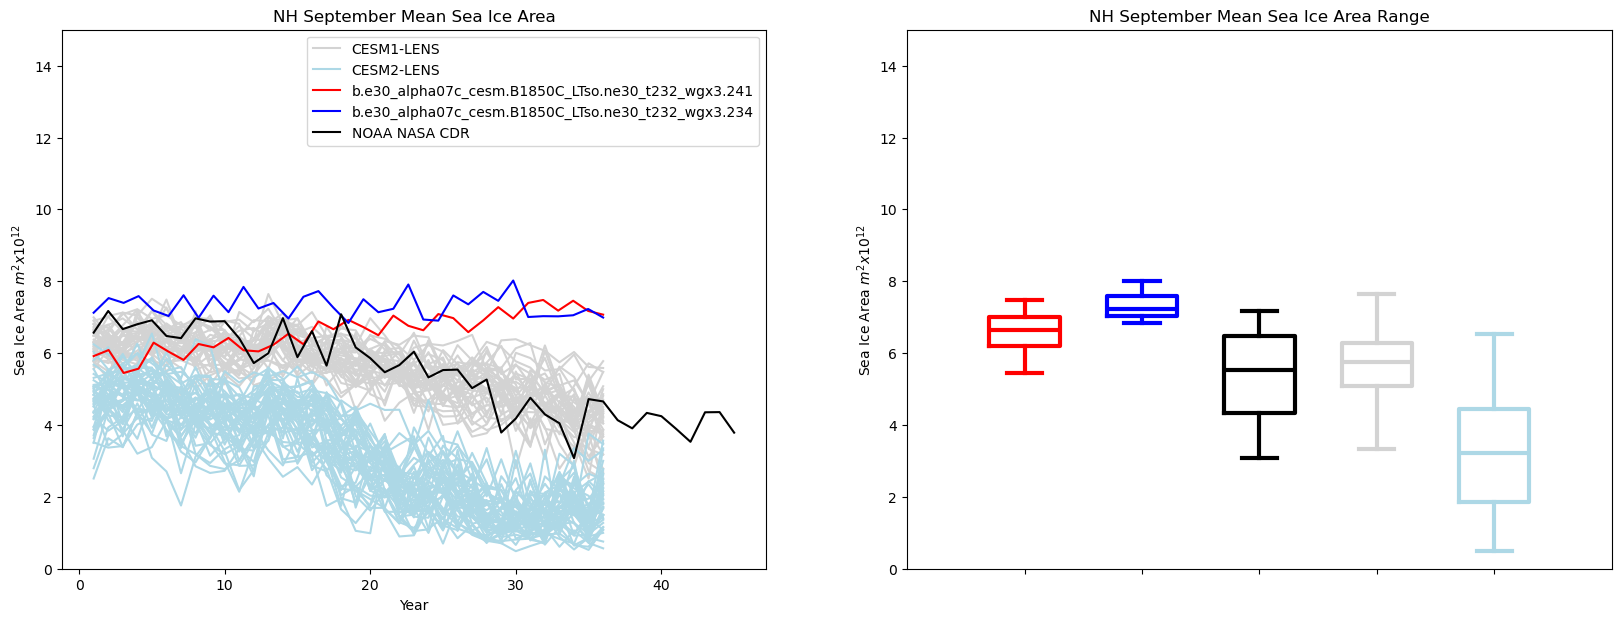

In [25]:
tag = "NH"

ds1_sep_nh = ds1_area.sel(time=(ds1_area.time.dt.month == 9))
ds2_sep_nh = ds2_area.sel(time=(ds2_area.time.dt.month == 9))

cesm1_aicetot_nh_sep = ds_cesm1_aicetot_nh["aice_monthly"].isel(nmonth=8)
cesm2_aicetot_nh_sep = ds_cesm2_aicetot_nh["aice_monthly"].isel(nmonth=8)

# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left)
fig = plt.figure(figsize=(20, 7))

### First panel, timeseries
ax = fig.add_subplot(1, 2, 1)
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_aicetot_nh_sep.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_aicetot_nh_sep.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-12,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_sep_nh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_sep_nh, x2, x1, color="blue")
ax.plot(x6, cdr_nh_sep, color="black")

plt.title(tag + " September Mean Sea Ice Area")
plt.ylim((0, 15))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

### Second panel, boxplot
ax = fig.add_subplot(1, 2, 2)
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = (
    cesm1_aicetot_nh_sep.isel(nyr=slice(60, 96)).stack(new=("n_members", "nyr"))
    * 1.0e-12
)
cesm2_tmp = (
    cesm2_aicetot_nh_sep.isel(nyr=slice(110, 146)).stack(new=("n_members", "nyr"))
    * 1.0e-12
)

# plot boxes
boxplots1 = ax.boxplot(ds1_sep_nh, showfliers=False, autorange=False, positions=[0.25])
boxplots2 = ax.boxplot(ds2_sep_nh, showfliers=False, autorange=False, positions=[0.50])
boxplots3 = ax.boxplot(cdr_nh_sep, showfliers=False, autorange=False, positions=[0.75])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False, positions=[1.00])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False, positions=[1.25])

# set colors for each box
setBoxColor(boxplots1, 8 * ["red"])
setBoxColor(boxplots2, 8 * ["blue"])
setBoxColor(boxplots3, 8 * ["black"])
setBoxColor(boxplots4, 8 * ["lightgrey"])
setBoxColor(boxplots5, 8 * ["lightblue"])

# set plot details
plt.title(tag + " September Mean Sea Ice Area Range")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.ylim((0, 15))
plt.xlim([0, 1.5])
plt.xticks(visible=False)

### Ice Volume

In [26]:
ds1_vol = (tarea * ds1.hi).isel(time=slice(-climo_nyears1 * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vol = (tarea * ds2.hi).isel(time=slice(-climo_nyears2 * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-13

(array([0.25, 0.5 , 0.75, 1.  ]),
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.0')])

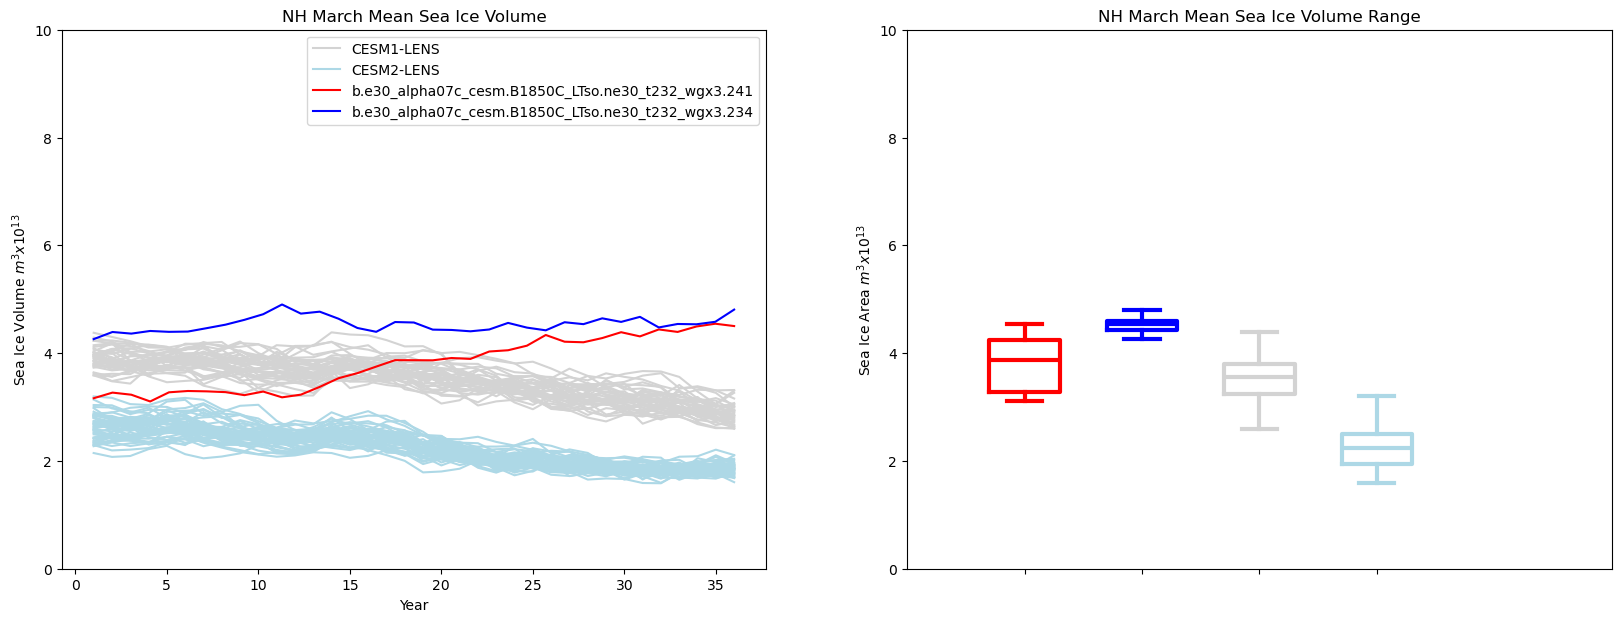

In [27]:
tag = "NH"

ds1_mar_nh = ds1_vol.sel(time=(ds1_vol.time.dt.month == 3))
ds2_mar_nh = ds2_vol.sel(time=(ds2_vol.time.dt.month == 3))

cesm1_hitot_nh_mar = ds_cesm1_hitot_nh["hi_monthly"].isel(nmonth=2)
cesm2_hitot_nh_mar = ds_cesm2_hitot_nh["hi_monthly"].isel(nmonth=2)

# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left)
fig = plt.figure(figsize=(20, 7))

### First panel, timeseries
ax = fig.add_subplot(1, 2, 1)
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_hitot_nh_mar.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_hitot_nh_mar.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-13,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_mar_nh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_mar_nh, x2, x1, color="blue")

plt.title(tag + " March Mean Sea Ice Volume")
plt.ylim((0, 10))
plt.xlabel("Year")
plt.ylabel("Sea Ice Volume $m^{3}x10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

### Second panel, boxplot
ax = fig.add_subplot(1, 2, 2)
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = (
    cesm1_hitot_nh_mar.isel(nyr=slice(60, 96)).stack(new=("n_members", "nyr")) * 1.0e-13
)
cesm2_tmp = (
    cesm2_hitot_nh_mar.isel(nyr=slice(110, 146)).stack(new=("n_members", "nyr"))
    * 1.0e-13
)

# plot boxes
boxplots1 = ax.boxplot(ds1_mar_nh, showfliers=False, autorange=False, positions=[0.25])
boxplots2 = ax.boxplot(ds2_mar_nh, showfliers=False, autorange=False, positions=[0.50])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False, positions=[0.75])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False, positions=[1.00])

# set colors for each box
setBoxColor(boxplots1, 8 * ["red"])
setBoxColor(boxplots2, 8 * ["blue"])
setBoxColor(boxplots4, 8 * ["lightgrey"])
setBoxColor(boxplots5, 8 * ["lightblue"])

# set plot details
plt.title(tag + " March Mean Sea Ice Volume Range")
plt.ylabel("Sea Ice Area $m^{3}x10^{13}$")
plt.ylim((0, 10))
plt.xlim([0, 1.5])
plt.xticks(visible=False)

(array([0.25, 0.5 , 0.75, 1.  ]),
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.0')])

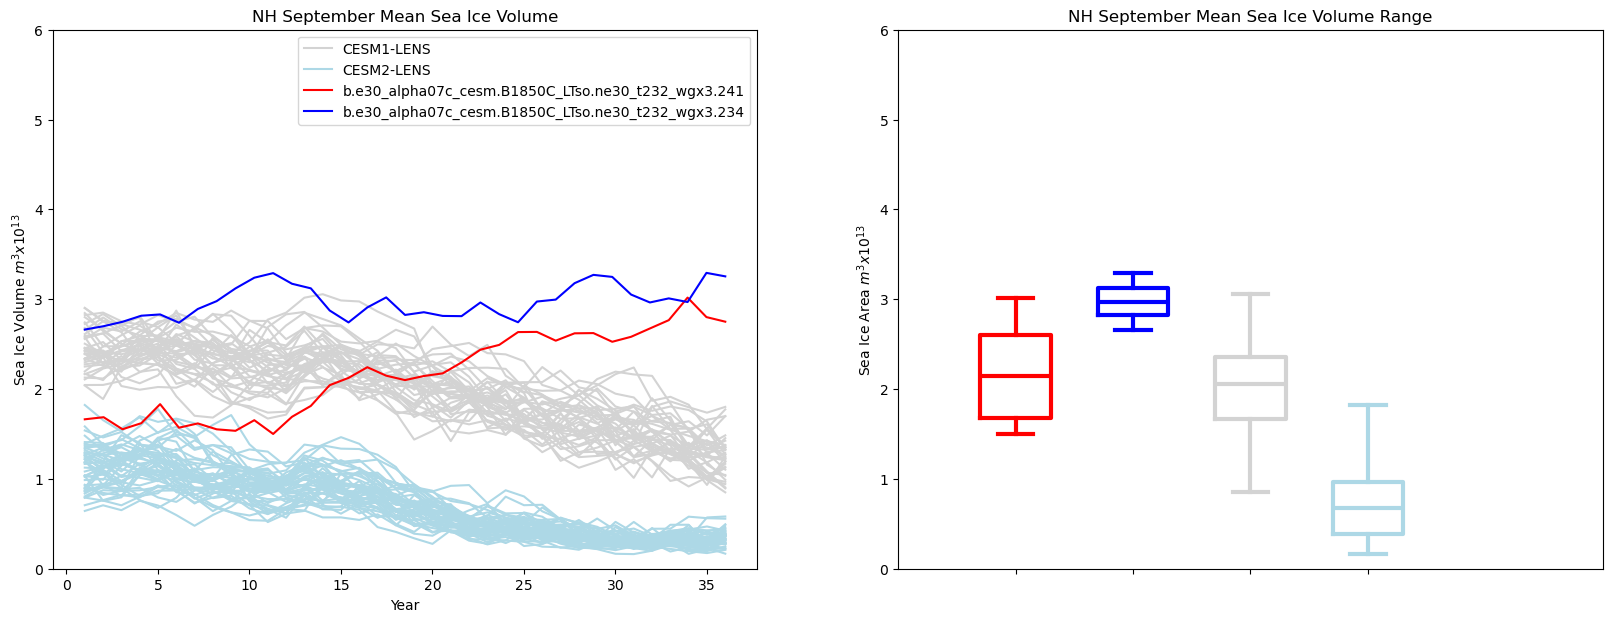

In [28]:
tag = "NH"

ds1_sep_nh = ds1_vol.sel(time=(ds1_vol.time.dt.month == 9))
ds2_sep_nh = ds2_vol.sel(time=(ds2_vol.time.dt.month == 9))

cesm1_hitot_nh_sep = ds_cesm1_hitot_nh["hi_monthly"].isel(nmonth=8)
cesm2_hitot_nh_sep = ds_cesm2_hitot_nh["hi_monthly"].isel(nmonth=8)

# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left)
fig = plt.figure(figsize=(20, 7))

### First panel, timeseries
ax = fig.add_subplot(1, 2, 1)
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_hitot_nh_sep.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_hitot_nh_sep.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-13,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_sep_nh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_sep_nh, x2, x1, color="blue")

plt.title(tag + " September Mean Sea Ice Volume")
plt.ylim((0, 6))
plt.xlabel("Year")
plt.ylabel("Sea Ice Volume $m^{3}x10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

### Second panel, boxplot
ax = fig.add_subplot(1, 2, 2)
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = (
    cesm1_hitot_nh_sep.isel(nyr=slice(60, 96)).stack(new=("n_members", "nyr")) * 1.0e-13
)
cesm2_tmp = (
    cesm2_hitot_nh_sep.isel(nyr=slice(110, 146)).stack(new=("n_members", "nyr"))
    * 1.0e-13
)

# plot boxes
boxplots1 = ax.boxplot(ds1_sep_nh, showfliers=False, autorange=False, positions=[0.25])
boxplots2 = ax.boxplot(ds2_sep_nh, showfliers=False, autorange=False, positions=[0.50])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False, positions=[0.75])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False, positions=[1.00])

# set colors for each box
setBoxColor(boxplots1, 8 * ["red"])
setBoxColor(boxplots2, 8 * ["blue"])
setBoxColor(boxplots4, 8 * ["lightgrey"])
setBoxColor(boxplots5, 8 * ["lightblue"])

# set plot details
plt.title(tag + " September Mean Sea Ice Volume Range")
plt.ylabel("Sea Ice Area $m^{3}x10^{13}$")
plt.ylim((0, 6))
plt.xlim([0, 1.5])
plt.xticks(visible=False)

## SH
- Maximum - September
- Minimum - February

### Ice Area

In [29]:
ds1_area = (tarea * ds1.aice).isel(time=slice(-climo_nyears1 * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area = (tarea * ds2.aice).isel(time=slice(-climo_nyears2 * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-12

(array([0.25, 0.5 , 0.75, 1.  , 1.25]),
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.0'),
  Text(1.25, 0, '1.25')])

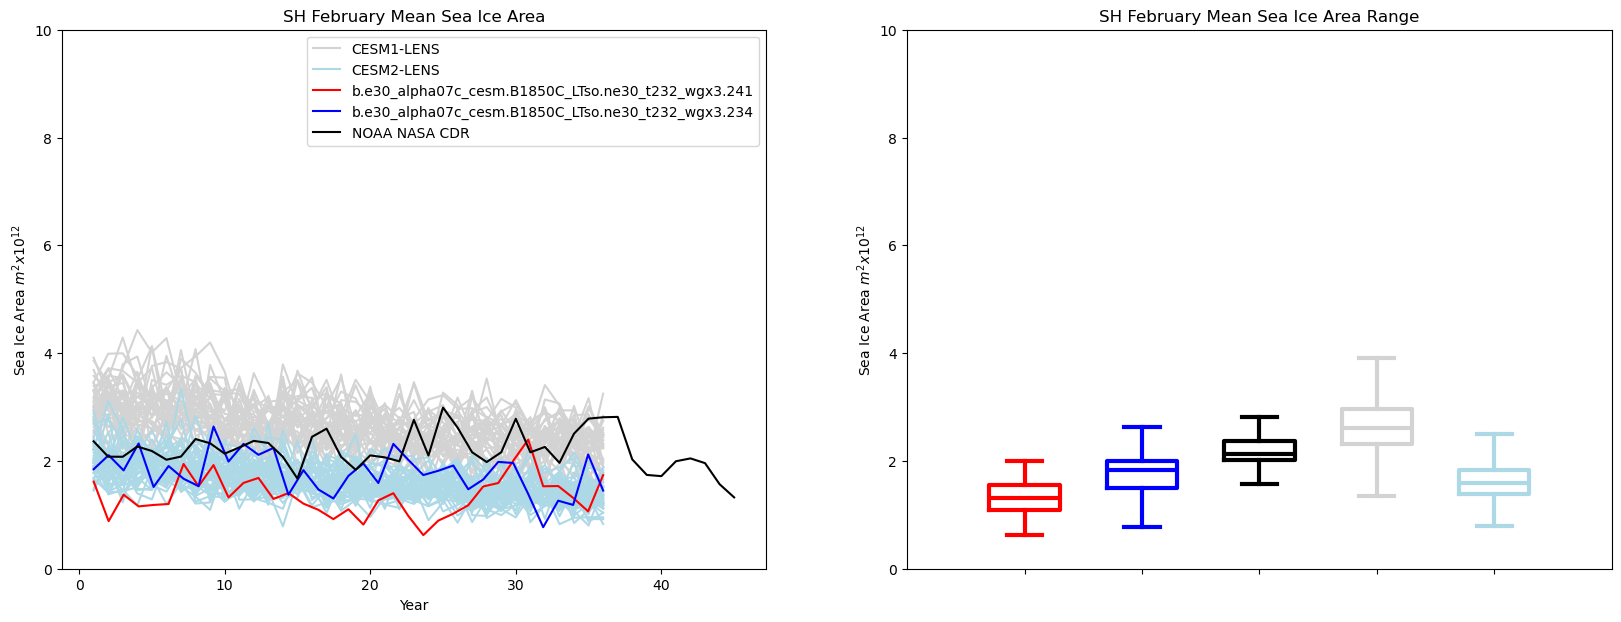

In [30]:
tag = "SH"

ds1_feb_sh = ds1_area.sel(time=(ds1_area.time.dt.month == 2))
ds2_feb_sh = ds2_area.sel(time=(ds2_area.time.dt.month == 2))

cesm1_aicetot_sh_feb = ds_cesm1_aicetot_sh["aice_monthly"].isel(nmonth=1)
cesm2_aicetot_sh_feb = ds_cesm2_aicetot_sh["aice_monthly"].isel(nmonth=1)

# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left)
fig = plt.figure(figsize=(20, 7))

### First panel, timeseries
ax = fig.add_subplot(1, 2, 1)
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_aicetot_sh_feb.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_aicetot_sh_feb.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-12,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_feb_sh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_feb_sh, x2, x1, color="blue")
ax.plot(x6, cdr_sh_feb, color="black")

plt.title(tag + " February Mean Sea Ice Area")
plt.ylim((0, 10))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

### Second panel, boxplot
ax = fig.add_subplot(1, 2, 2)
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = (
    cesm1_aicetot_sh_feb.isel(nyr=slice(60, 96)).stack(new=("n_members", "nyr"))
    * 1.0e-12
)
cesm2_tmp = (
    cesm2_aicetot_sh_feb.isel(nyr=slice(110, 146)).stack(new=("n_members", "nyr"))
    * 1.0e-12
)

# plot boxes
boxplots1 = ax.boxplot(ds1_feb_sh, showfliers=False, autorange=False, positions=[0.25])
boxplots2 = ax.boxplot(ds2_feb_sh, showfliers=False, autorange=False, positions=[0.50])
boxplots3 = ax.boxplot(cdr_sh_feb, showfliers=False, autorange=False, positions=[0.75])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False, positions=[1.00])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False, positions=[1.25])

# set colors for each box
setBoxColor(boxplots1, 8 * ["red"])
setBoxColor(boxplots2, 8 * ["blue"])
setBoxColor(boxplots3, 8 * ["black"])
setBoxColor(boxplots4, 8 * ["lightgrey"])
setBoxColor(boxplots5, 8 * ["lightblue"])

# set plot details
plt.title(tag + " February Mean Sea Ice Area Range")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.ylim((0, 10))
plt.xlim([0, 1.5])
plt.xticks(visible=False)

(array([0.25, 0.5 , 0.75, 1.  , 1.25]),
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.0'),
  Text(1.25, 0, '1.25')])

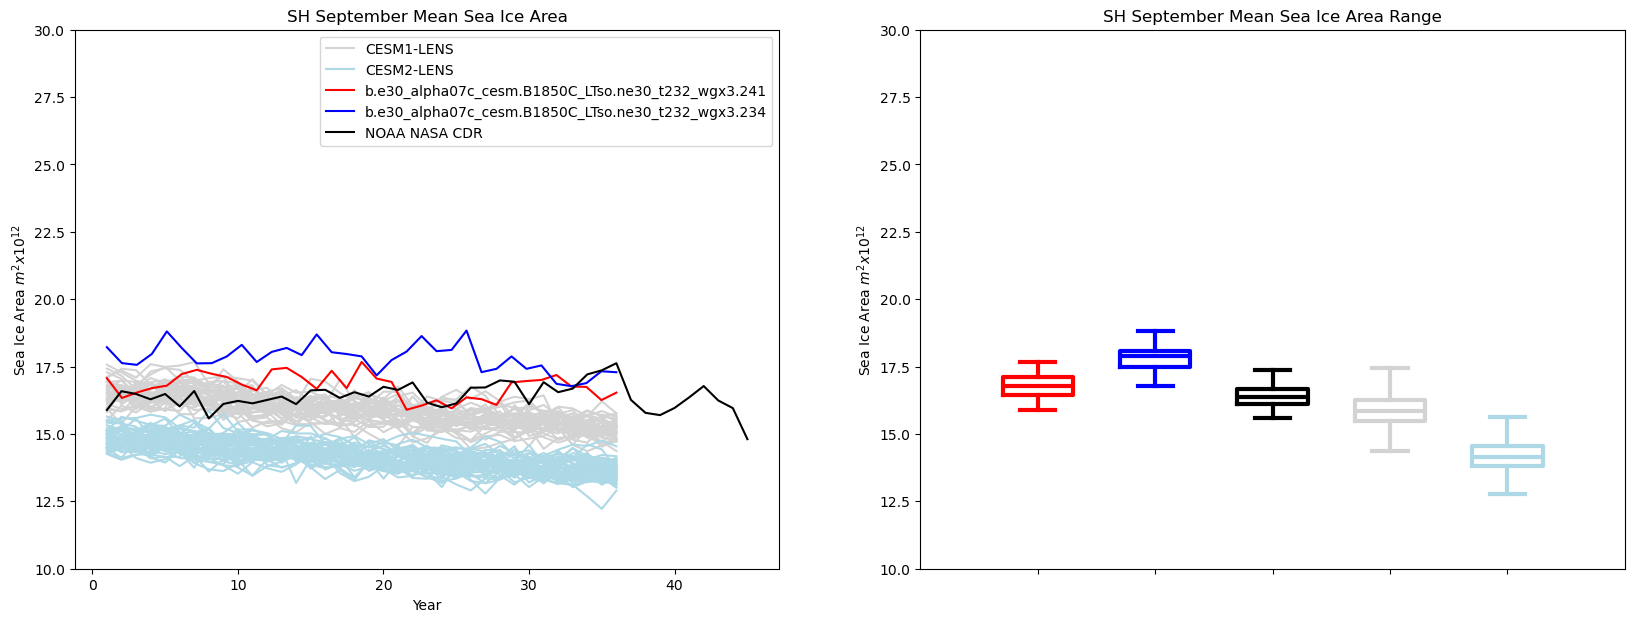

In [31]:
tag = "SH"

ds1_sep_sh = ds1_area.sel(time=(ds1_area.time.dt.month == 9))
ds2_sep_sh = ds2_area.sel(time=(ds2_area.time.dt.month == 9))

cesm1_aicetot_sh_sep = ds_cesm1_aicetot_sh["aice_monthly"].isel(nmonth=8)
cesm2_aicetot_sh_sep = ds_cesm2_aicetot_sh["aice_monthly"].isel(nmonth=8)

# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left)
fig = plt.figure(figsize=(20, 7))

### First panel, timeseries
ax = fig.add_subplot(1, 2, 1)
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_aicetot_sh_sep.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_aicetot_sh_sep.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-12,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_sep_sh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_sep_sh, x2, x1, color="blue")
ax.plot(x6, cdr_sh_sep, color="black")

plt.title(tag + " September Mean Sea Ice Area")
plt.ylim((10, 30))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

### Second panel, boxplot
ax = fig.add_subplot(1, 2, 2)
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = (
    cesm1_aicetot_sh_sep.isel(nyr=slice(60, 96)).stack(new=("n_members", "nyr"))
    * 1.0e-12
)
cesm2_tmp = (
    cesm2_aicetot_sh_sep.isel(nyr=slice(110, 146)).stack(new=("n_members", "nyr"))
    * 1.0e-12
)

# plot boxes
boxplots1 = ax.boxplot(ds1_sep_sh, showfliers=False, autorange=False, positions=[0.25])
boxplots2 = ax.boxplot(ds2_sep_sh, showfliers=False, autorange=False, positions=[0.50])
boxplots3 = ax.boxplot(cdr_sh_sep, showfliers=False, autorange=False, positions=[0.75])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False, positions=[1.00])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False, positions=[1.25])

# set colors for each box
setBoxColor(boxplots1, 8 * ["red"])
setBoxColor(boxplots2, 8 * ["blue"])
setBoxColor(boxplots3, 8 * ["black"])
setBoxColor(boxplots4, 8 * ["lightgrey"])
setBoxColor(boxplots5, 8 * ["lightblue"])

# set plot details
plt.title(tag + " September Mean Sea Ice Area Range")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.ylim((10, 30))
plt.xlim([0, 1.5])
plt.xticks(visible=False)

### Ice Volume

In [32]:
ds1_vol = (tarea * ds1.hi).isel(time=slice(-climo_nyears1 * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vol = (tarea * ds2.hi).isel(time=slice(-climo_nyears2 * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-13

(array([0.25, 0.5 , 0.75, 1.  ]),
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.0')])

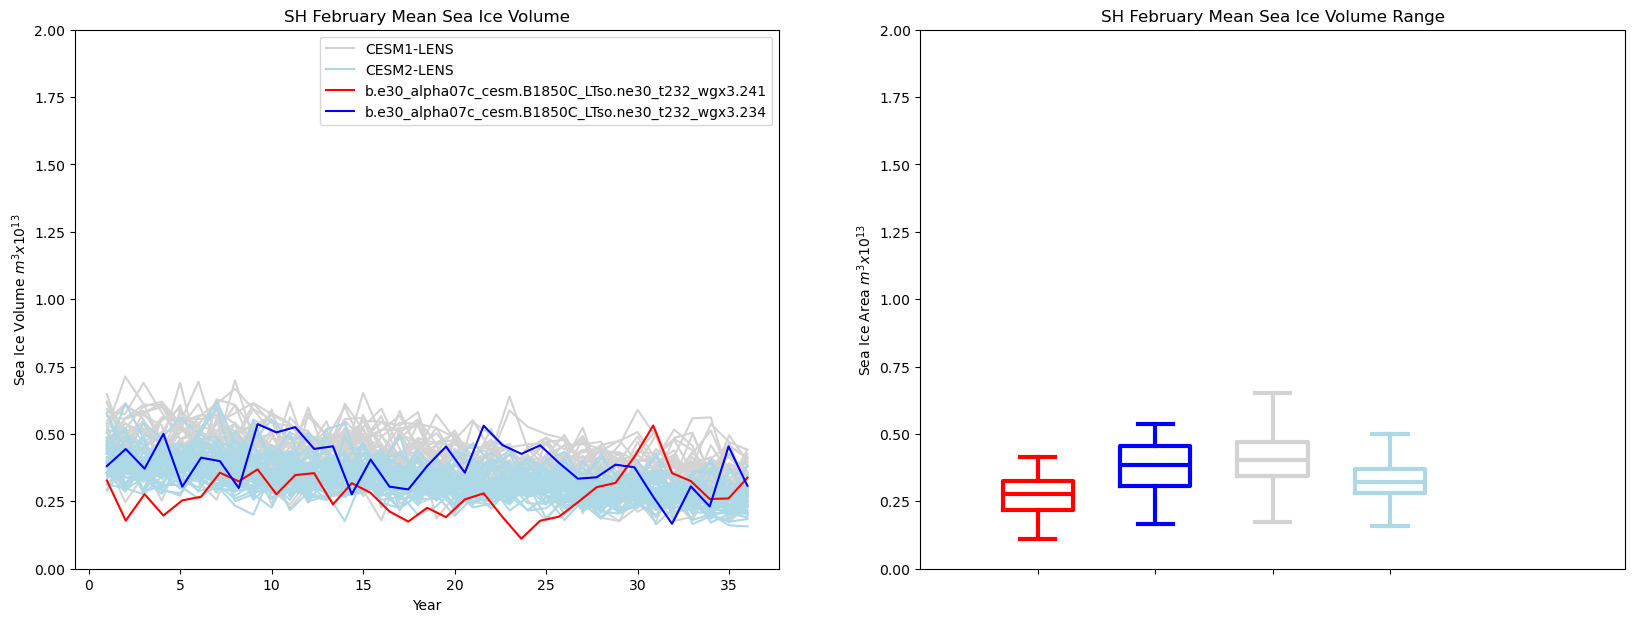

In [33]:
tag = "SH"

ds1_feb_sh = ds1_vol.sel(time=(ds1_vol.time.dt.month == 3))
ds2_feb_sh = ds2_vol.sel(time=(ds2_vol.time.dt.month == 3))

cesm1_hitot_sh_feb = ds_cesm1_hitot_sh["hi_monthly"].isel(nmonth=2)
cesm2_hitot_sh_feb = ds_cesm2_hitot_sh["hi_monthly"].isel(nmonth=2)

# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left)
fig = plt.figure(figsize=(20, 7))

### First panel, timeseries
ax = fig.add_subplot(1, 2, 1)
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_hitot_sh_feb.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_hitot_sh_feb.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-13,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_feb_sh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_feb_sh, x2, x1, color="blue")

plt.title(tag + " February Mean Sea Ice Volume")
plt.ylim((0, 2))
plt.xlabel("Year")
plt.ylabel("Sea Ice Volume $m^{3}x10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

### Second panel, boxplot
ax = fig.add_subplot(1, 2, 2)
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = (
    cesm1_hitot_sh_feb.isel(nyr=slice(60, 96)).stack(new=("n_members", "nyr")) * 1.0e-13
)
cesm2_tmp = (
    cesm2_hitot_sh_feb.isel(nyr=slice(110, 146)).stack(new=("n_members", "nyr"))
    * 1.0e-13
)

# plot boxes
boxplots1 = ax.boxplot(ds1_feb_sh, showfliers=False, autorange=False, positions=[0.25])
boxplots2 = ax.boxplot(ds2_feb_sh, showfliers=False, autorange=False, positions=[0.50])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False, positions=[0.75])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False, positions=[1.00])

# set colors for each box
setBoxColor(boxplots1, 8 * ["red"])
setBoxColor(boxplots2, 8 * ["blue"])
setBoxColor(boxplots4, 8 * ["lightgrey"])
setBoxColor(boxplots5, 8 * ["lightblue"])

# set plot details
plt.title(tag + " February Mean Sea Ice Volume Range")
plt.ylabel("Sea Ice Area $m^{3}x10^{13}$")
plt.ylim((0, 2))
plt.xlim([0, 1.5])
plt.xticks(visible=False)

(array([0.25, 0.5 , 0.75, 1.  ]),
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.0')])

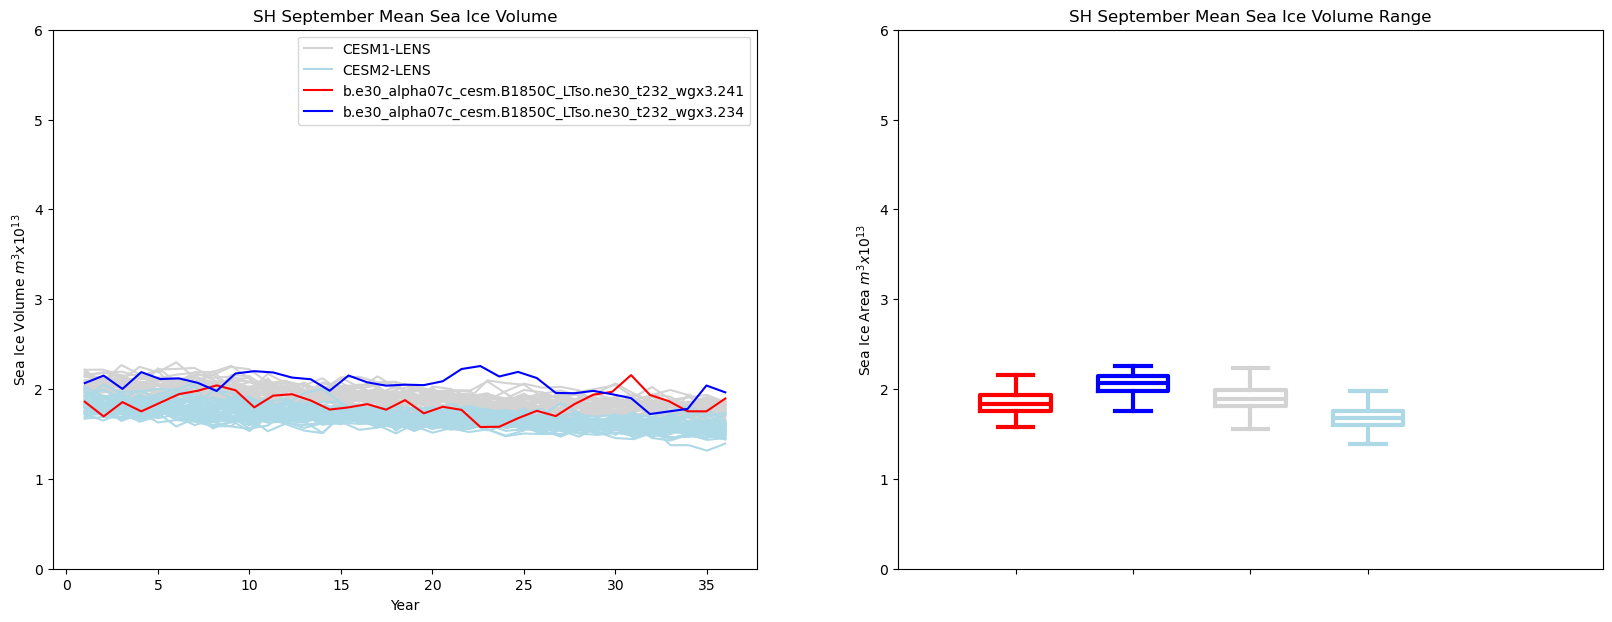

In [34]:
tag = "SH"

ds1_sep_sh = ds1_vol.sel(time=(ds1_vol.time.dt.month == 9))
ds2_sep_sh = ds2_vol.sel(time=(ds2_vol.time.dt.month == 9))

cesm1_hitot_sh_sep = ds_cesm1_hitot_sh["hi_monthly"].isel(nmonth=8)
cesm2_hitot_sh_sep = ds_cesm2_hitot_sh["hi_monthly"].isel(nmonth=8)

# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left)
fig = plt.figure(figsize=(20, 7))

### First panel, timeseries
ax = fig.add_subplot(1, 2, 1)
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_hitot_sh_sep.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_hitot_sh_sep.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-13,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_sep_sh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_sep_sh, x2, x1, color="blue")

plt.title(tag + " September Mean Sea Ice Volume")
plt.ylim((0, 6))
plt.xlabel("Year")
plt.ylabel("Sea Ice Volume $m^{3}x10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

### Second panel, boxplot
ax = fig.add_subplot(1, 2, 2)
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = (
    cesm1_hitot_sh_sep.isel(nyr=slice(60, 96)).stack(new=("n_members", "nyr")) * 1.0e-13
)
cesm2_tmp = (
    cesm2_hitot_sh_sep.isel(nyr=slice(110, 146)).stack(new=("n_members", "nyr"))
    * 1.0e-13
)

# plot boxes
boxplots1 = ax.boxplot(ds1_sep_sh, showfliers=False, autorange=False, positions=[0.25])
boxplots2 = ax.boxplot(ds2_sep_sh, showfliers=False, autorange=False, positions=[0.50])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False, positions=[0.75])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False, positions=[1.00])

# set colors for each box
setBoxColor(boxplots1, 8 * ["red"])
setBoxColor(boxplots2, 8 * ["blue"])
setBoxColor(boxplots4, 8 * ["lightgrey"])
setBoxColor(boxplots5, 8 * ["lightblue"])

# set plot details
plt.title(tag + " September Mean Sea Ice Volume Range")
plt.ylabel("Sea Ice Area $m^{3}x10^{13}$")
plt.ylim((0, 6))
plt.xlim([0, 1.5])
plt.xticks(visible=False)

# Labrador Sea Timeseries

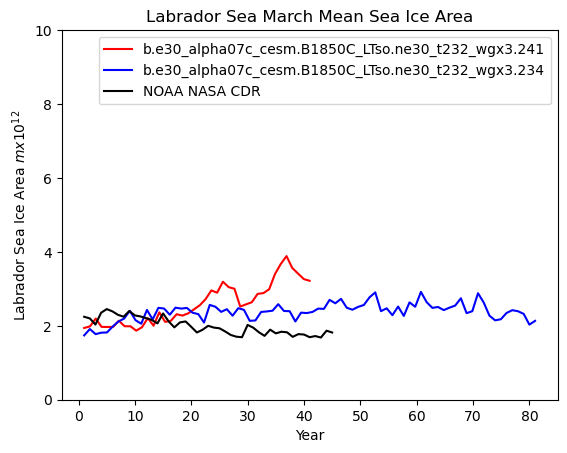

In [35]:
latm = cice_masks["Lab_lat"]
lonm = cice_masks["Lab_lon"]

lon = np.where(TLON < 0, TLON + 360.0, TLON)
mask1 = np.where(np.logical_and(TLAT > latm[0], TLAT < latm[1]), 1.0, 0.0)
mask2 = np.where(np.logical_or(lon > lonm[0], lon < lonm[1]), 1.0, 0.0)
mask = mask1 * mask2

ds1_lab = (mask * tarea * ds1.aice).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_lab = (mask * tarea * ds2.aice).sum(dim=["nj", "ni"]) * 1.0e-12

# just want maximum extent (so March)
ds1_lab_mar = ds1_lab.sel(time=ds1_lab.time.dt.month == 3)
ds2_lab_mar = ds2_lab.sel(time=ds2_lab.time.dt.month == 3)

# Set up axes
if first_year > 1 and base_first_year > 1:
    model_start_year1 = end_year - len(ds1_lab_mar.time) + 1
    model_end_year1 = end_year
    model_start_year2 = base_end_year - len(ds2_lab_mar.time) + 1
    model_end_year2 = base_end_year
else:
    model_start_year1 = 1
    model_end_year1 = len(ds1_lab_mar.time) + 1
    model_start_year2 = 1
    model_end_year2 = len(ds2_lab_mar.time) + 1

del x1
del x2

x1 = np.linspace(model_start_year1, model_end_year1, len(ds1_lab_mar.time))
x2 = np.linspace(model_start_year2, model_end_year2, len(ds2_lab_mar.time))

plt_plot_len_x_might_be_one(ds1_lab_mar, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_lab_mar, x2, x1, color="blue")
plt.plot(x6, cdr_lab_mar, color="black")

plt.title("Labrador Sea March Mean Sea Ice Area")
plt.ylim((0, 10))
plt.xlabel("Year")
plt.ylabel("Labrador Sea Ice Area $m x 10^{12}$")
plt.legend(handles=[p3, p4, p5])

In [36]:
if not serial:
    client.shutdown()